In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import scan
import simulate_data
import h5py
import sys
np.set_printoptions(threshold=sys.maxsize)


In [2]:
def get_imgs(N, pattern_template):
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, None
    
    win_size = (N,1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1
            
    pattern_img = pattern_img.transpose((1,2,0))
    
    return pattern_template, pattern_img

In [3]:
f = h5py.File(r'C:/Users/miles/Projects/datasets/heidelberg/shd_test.h5')

In [4]:
counts = []
for k in np.unique(f['labels']):
    counts.append(list(f['labels']).count(k))
np.array(counts)

array([103, 108, 105, 102, 116, 110, 109, 109, 114, 103, 122, 121, 121,
       120, 115, 112, 118, 121, 123, 112])

In [5]:
counts = []
for k in np.unique(f['extra']['speaker']):
    counts.append(list(f['extra']['speaker']).count(k))
np.array(counts)

array([ 47,  47,  52,  38, 900, 940,  23,  40,  41,  43,  41,  52])

In [6]:
# if I want to look at speakers, maybe 4 and 5 are the best ones to consider?

In [7]:
np.sum((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))

42

In [8]:
np.sum(np.array(f['labels'])==0), np.sum(np.array(f['extra']['speaker']) == 4)

(103, 900)

In [9]:

idc = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0]
idc

array([   6,   26,   43,   64,  200,  203,  209,  245,  420,  447,  487,
        495,  653,  658,  721,  763,  805, 1010, 1057, 1105, 1117, 1159,
       1250, 1292, 1378, 1416, 1428, 1438, 1503, 1573, 1709, 1714, 1729,
       1750, 1830, 1838, 1909, 1932, 1958, 2090, 2126, 2207], dtype=int64)

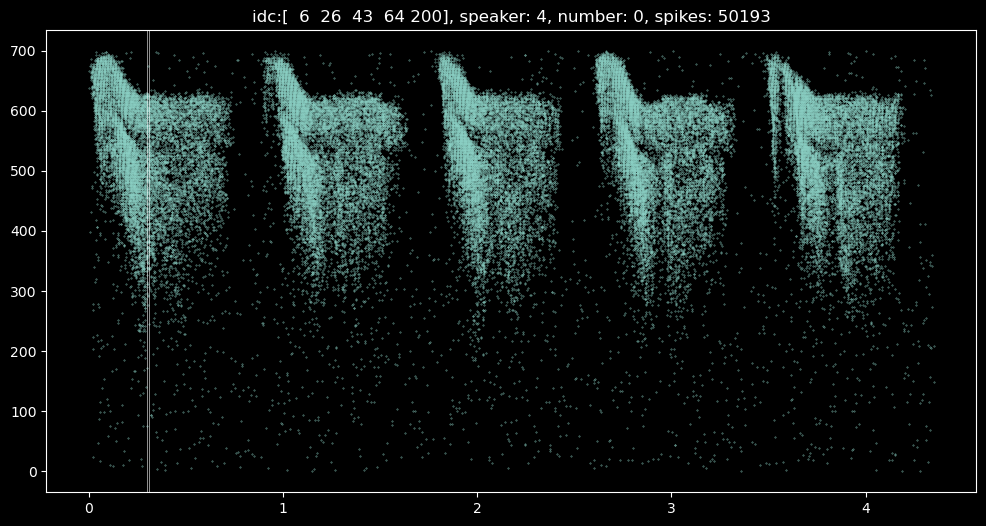

In [10]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0][:5]

D=10/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [11]:
# Convert the data into something that is easily readable by my parameter scan algo.
filename = f'combined-{idc}-{int(D*1000)}'

if not os.path.isfile(''.join((os.getcwd(),f'\\{filename}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units.astype('int'),window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{filename}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{filename}.pkl loaded!')

    

combined-[  6  26  43  64 200]-10.pkl loaded!


In [12]:
pattern_template, all_times, window_time, cluster_time, sequence_time = results_scan.values()

In [14]:
(window_time + cluster_time + sequence_time)/60

21.76443544626236

In [43]:
times = (times*1000).astype('int')
units = units.astype('int')

In [44]:
pattern_template_copy, pattern_img = get_imgs(1+max(units.astype('int')),pattern_template)

raster = np.zeros((max(times)+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(4352, 700) (700, 39, 702)
done


100%|████████████████████████████████████████████████████████████████████████████████| 702/702 [06:22<00:00,  1.84it/s]


### speed comparison of sparse convolution

In [23]:
def sparse_convolution(spikes,labels, pattern_):
    # Extract unique channels from the pattern
    pattern = pattern_.copy()
    filt_labels = pattern.T[1]
    filt_spikes = spikes[np.isin(labels, filt_labels)]
    filt_labels = labels[np.isin(labels, filt_labels)]
    set_raster = set([(a,b) for a,b in zip(filt_spikes,filt_labels)])
    d = np.max(pattern.T[0])
    out = np.zeros((1+np.max(spikes)-d))
    t=0
    while t <= (np.max(spikes)-d):
        pattern.T[0]+=1
        set_pattern = set([tuple(k) for k in pattern])
        out[t] = len(set_pattern.intersection(set_raster))
        t+=1
                
    return out

In [37]:
times = (times*1000).astype('int')
units = units.astype('int')

In [25]:
sanity_check = []
for k in tqdm(pattern_template):
    sanity_check.append(sparse_convolution(times,units, k))

  0%|                                                                                          | 0/702 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [45]:
sanity_check.shape

(4352, 702)

In [23]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>=5]), np.array(counts[counts>=5]), np.array([len(k) for k in pattern_template[patterns[counts>=5]]])

(array([104, 284, 322, 372, 423, 424, 428, 442, 445, 464, 474, 483, 505,
        532, 539, 548, 549, 551, 580, 594, 605, 608, 613, 635, 637, 638,
        640, 643, 659, 663, 664, 666, 672, 676, 677, 678, 679, 680, 689,
        699], dtype=int64),
 array([  5,   5,   8,   5,   6,   5,   8,   5,   5,   5,   5,   7,   6,
        202,   5,   5,   6,   7,  28,   5,   6,   5,   5,   5,   5,   5,
          8,   6,   5,   5,   7,   5,   5,   5,   7,   5,   5,   7,   8,
         55]),
 array([33, 23,  6, 29, 32, 18, 16, 24, 36, 31, 32, 21,  4,  1, 11, 37, 41,
         3,  2, 66, 20, 39, 27, 26, 29, 32, 17, 28, 21, 42, 18, 37, 10, 13,
        10, 24, 16, 17,  9,  1]))

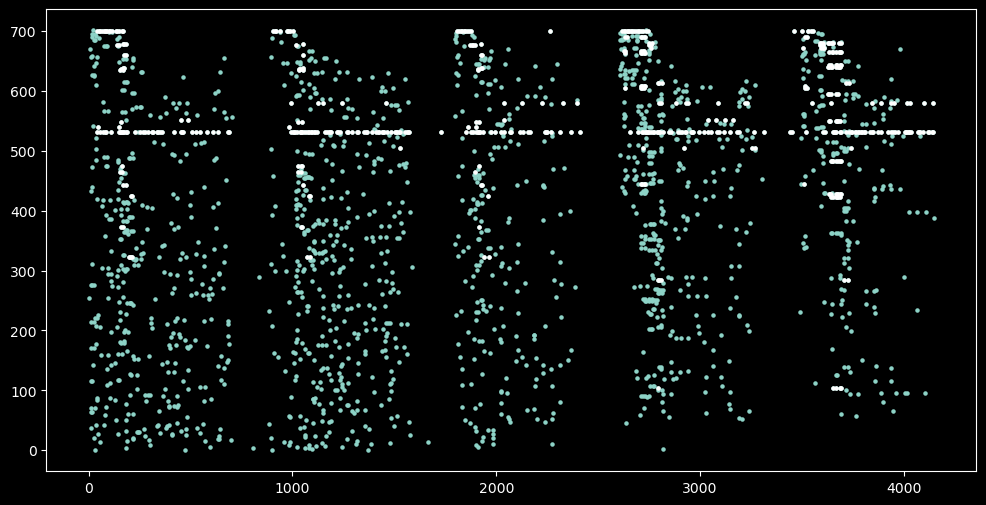

In [24]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=5][np.where(sanity_check[:,patterns[counts>=5]]==1)[1]], np.where(sanity_check[:,patterns[counts>=5]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

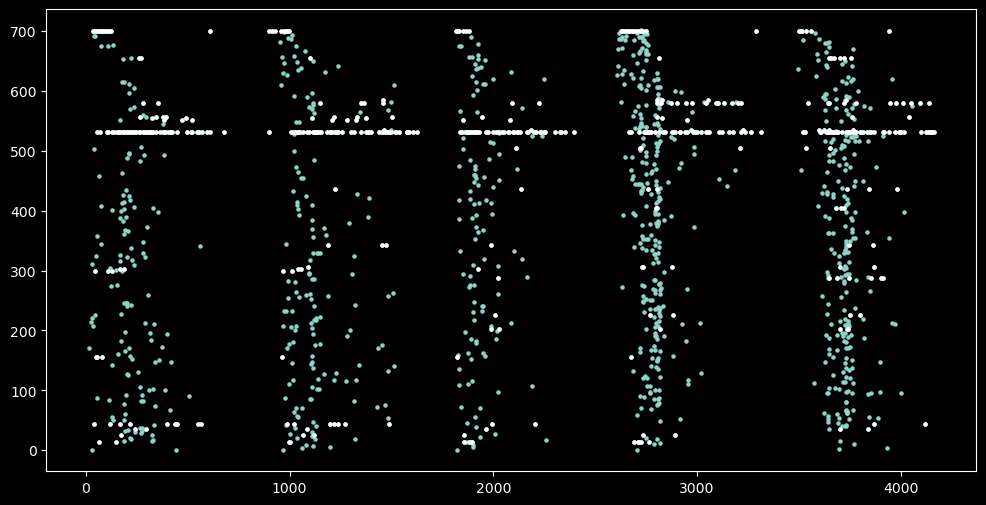

In [24]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=5][np.where(sanity_check[:,patterns[counts>=5]]==1)[1]], np.where(sanity_check[:,patterns[counts>=5]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

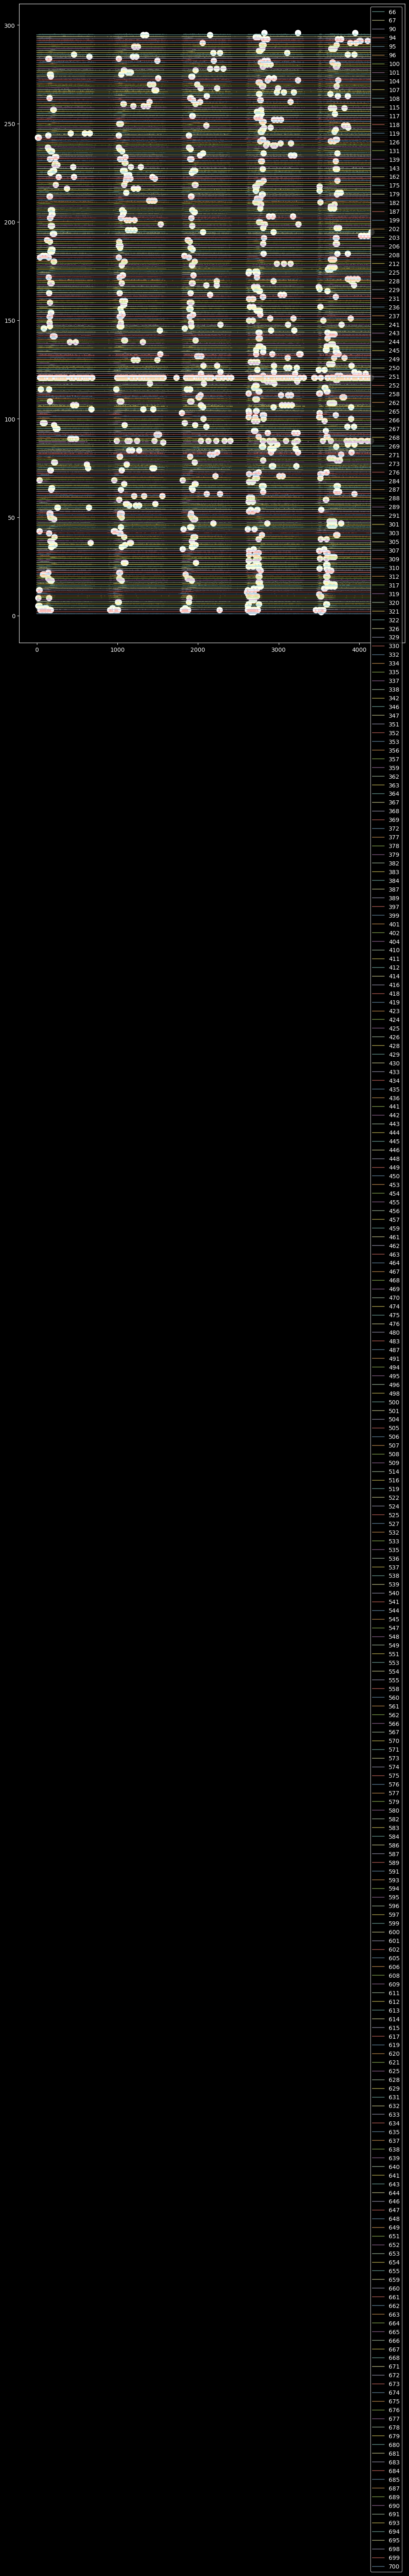

In [25]:
plt.figure(figsize=(12,20))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

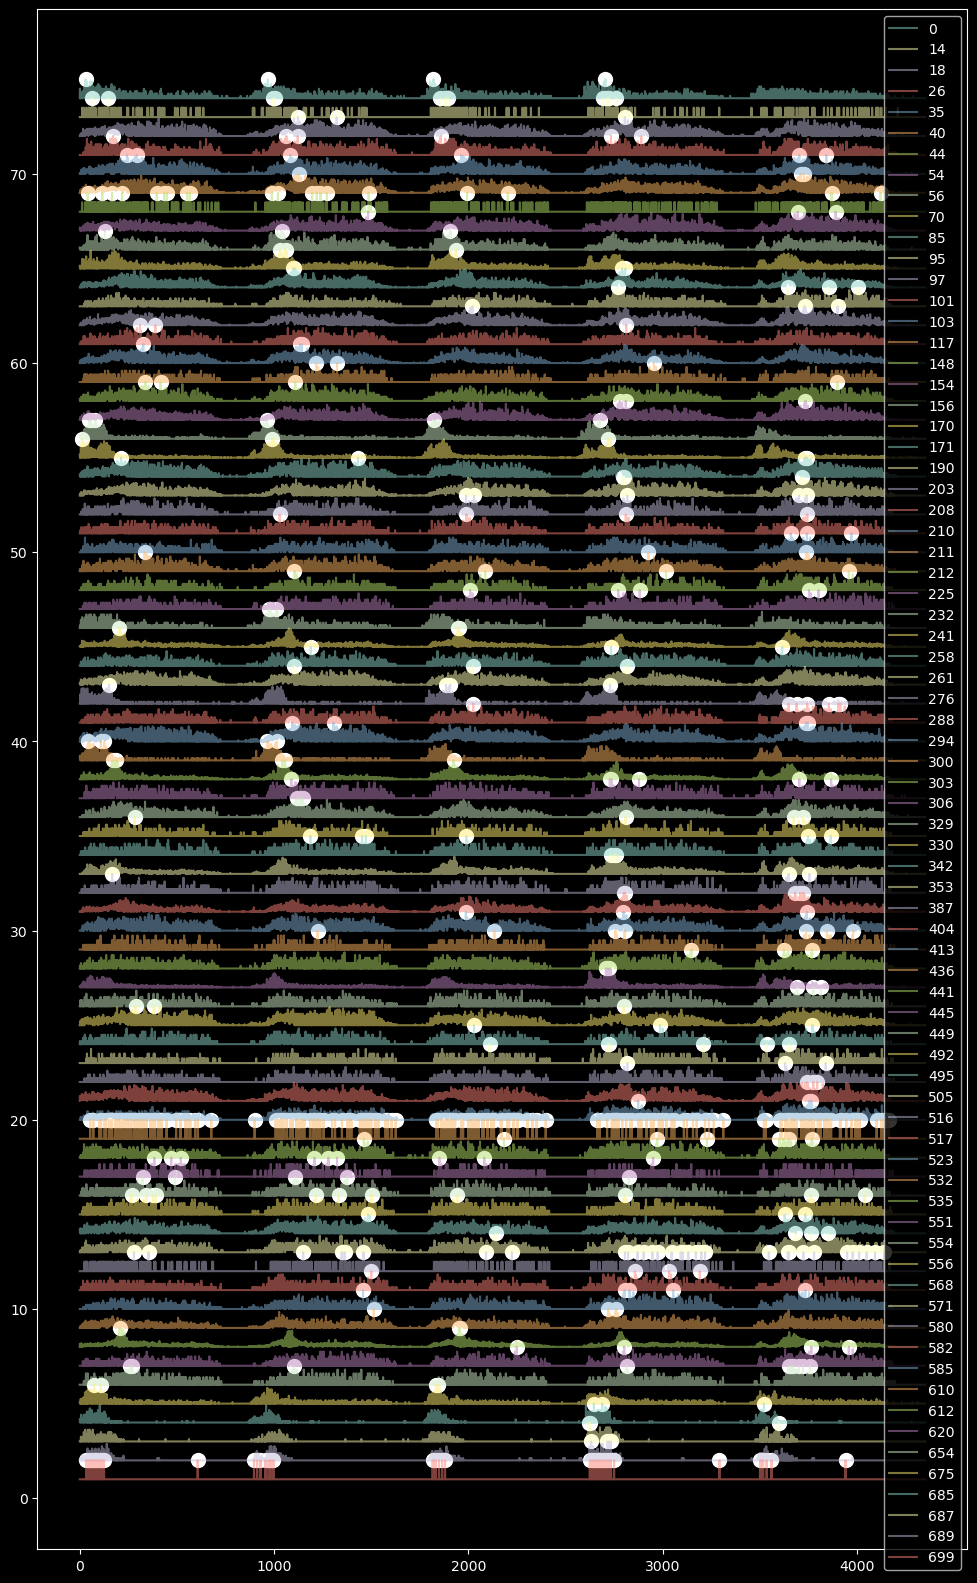

In [25]:
plt.figure(figsize=(12,20))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

# Below here is 3 digits train

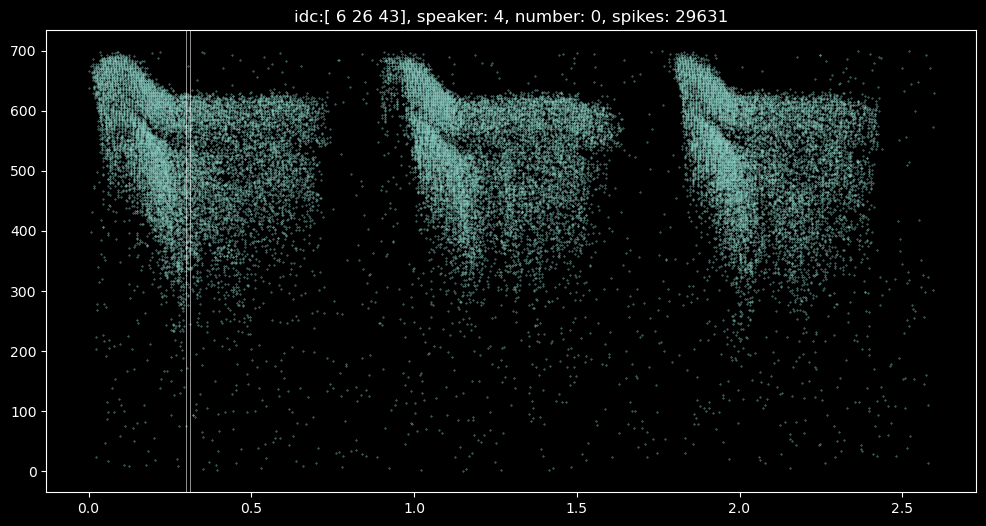

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0][:3]

D=10/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [13]:
# Convert the data into something that is easily readable by my parameter scan algo.
filename = f'combined-{idc}-{int(D*1000)}'

if not os.path.isfile(''.join((os.getcwd(),f'\\{filename}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units.astype('int'),window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{filename}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{filename}.pkl loaded!')

    

29631 Windows
319 patterns found..... 100%10.01 | opt_cutoff - 1.09 | most_detections - 7etections - 7
run_time: 389.29747676849365 s


In [14]:
pattern_template_copy, pattern_img = get_imgs(1+max(units.astype('int')),pattern_template)

raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(2598, 700) (700, 39, 319)
done


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:40<00:00,  7.82it/s]


In [15]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>2]), np.array(counts[counts>2]), np.array([len(k) for k in pattern_template[patterns[counts>2]]])

(array([  5,   9, 185, 239, 259, 282, 298], dtype=int64),
 array([18, 40,  3,  3,  3,  3,  3]),
 array([  4,   2,  23, 215,  27,  40,  34]))

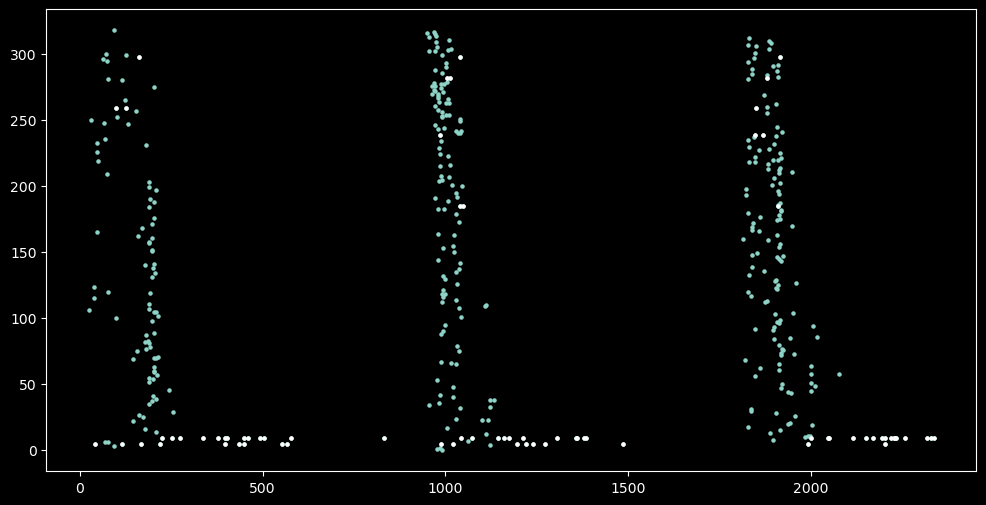

In [16]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]==1)[1]], np.where(sanity_check[:,patterns[counts>2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

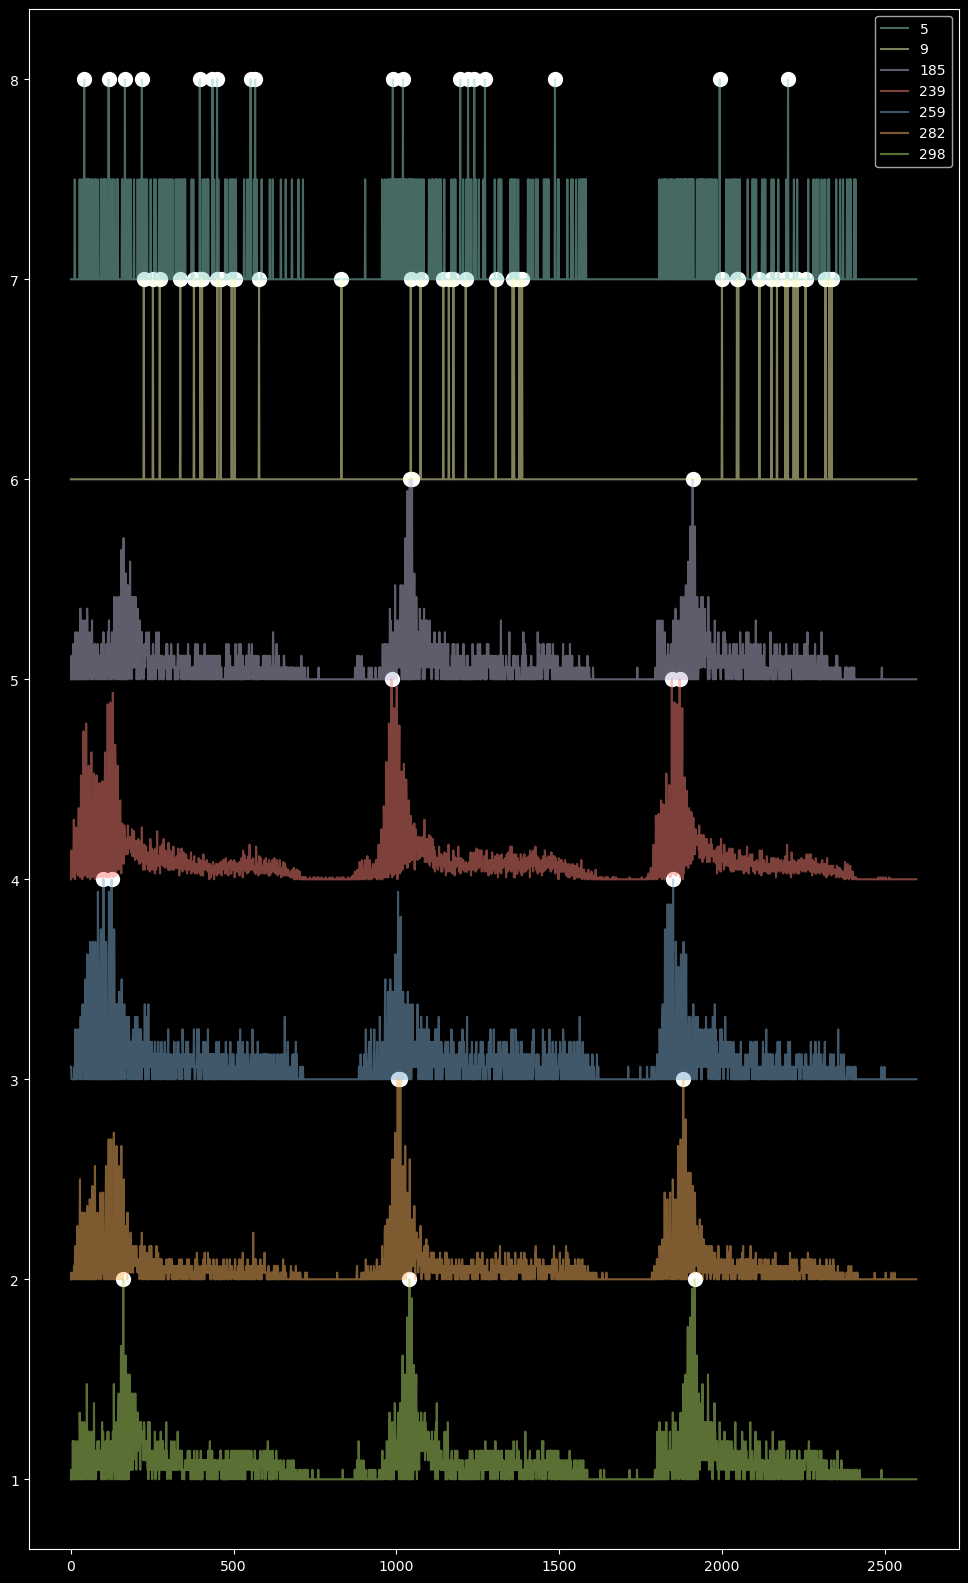

In [17]:
plt.figure(figsize=(12,20))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

# Below here was just tested on 3 stitched digits

In [60]:
pattern_template_copy, pattern_img = get_imgs(1+max(units.astype('int')),pattern_template)

raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(2598, 700) (700, 19, 363)
done


  0%|                                                                                          | 0/363 [00:00<?, ?it/s]C:\Users\miles\AppData\Local\Temp\ipykernel_12808\2679264454.py:14: RuntimeWarning: invalid value encountered in divide
  sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])
100%|████████████████████████████████████████████████████████████████████████████████| 363/363 [00:26<00:00, 13.47it/s]


In [61]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>2]), np.array(counts[counts>2]), np.array([len(k) for k in pattern_template[patterns[counts>2]]])

(array([  1,   8,  10,  18,  25,  26,  30,  32,  50,  54,  59,  82,  96,
        100, 130, 174, 197, 199, 250, 258, 281, 308, 317, 336], dtype=int64),
 array([ 3, 45,  3,  3,  3,  3, 24,  3,  3,  3,  3,  3,  4,  3,  3,  3,  5,
         3,  5,  3,  3,  8,  3,  4]),
 array([92,  2, 33, 70, 41, 46,  1, 79, 67, 51, 16, 66, 32, 46, 42,  6, 80,
        42, 95, 12, 38, 18, 45, 19]))

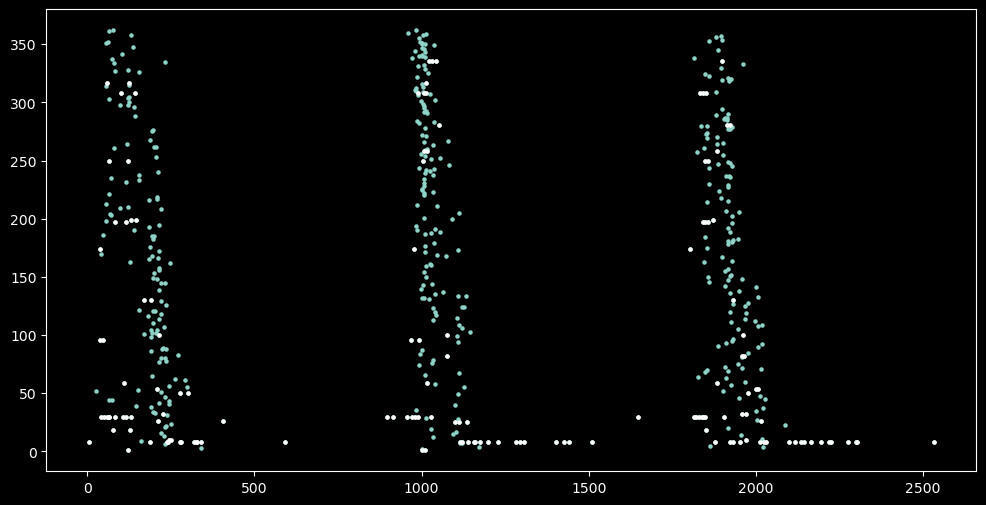

In [64]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]==1)[1]], np.where(sanity_check[:,patterns[counts>2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

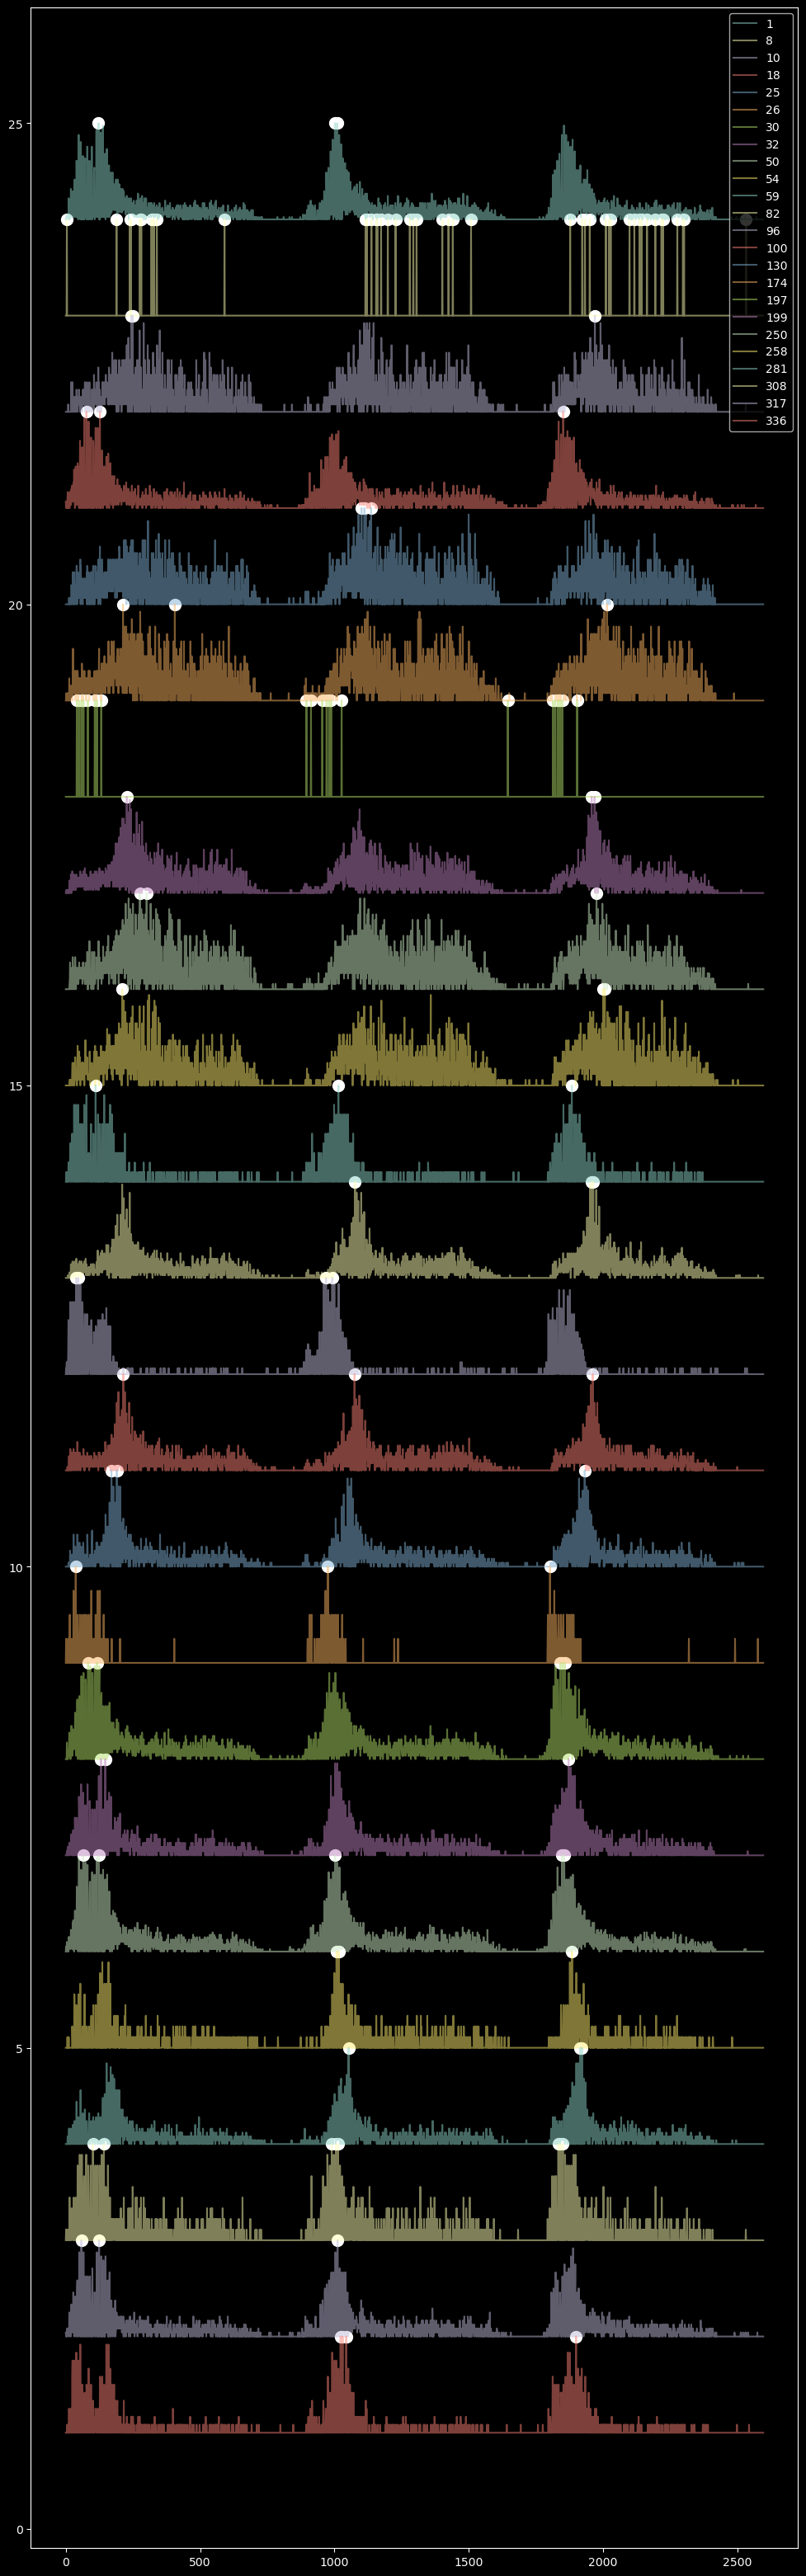

In [77]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

# Let's see what happens when we convolve these patterns on spoken digits for which it wasn't trained

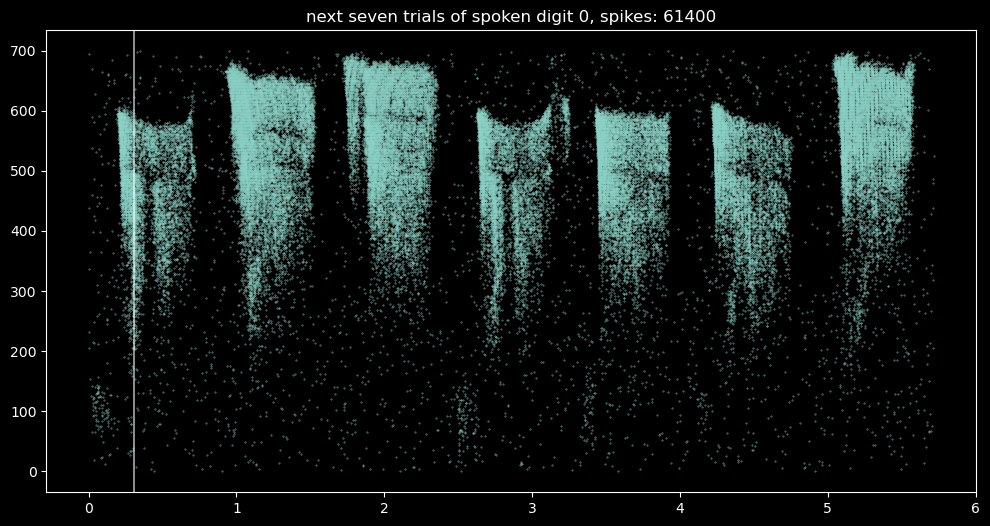

In [65]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])==0))[0][3:10]

D=5/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

# plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.title(f'next seven trials of spoken digit 0, spikes: {len(times)}')

plt.show()

In [67]:
raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(5719, 700) (700, 19, 400)
done


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:09<00:00,  5.74it/s]


In [68]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>=2]), np.array(counts[counts>=2]), np.array([len(k) for k in pattern_template[patterns[counts>=2]]])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  13,  16,  17,  19,
         20,  23,  24,  26,  29,  30,  32,  33,  34,  35,  37,  40,  44,
         45,  47,  48,  49,  52,  55,  56,  57,  58,  59,  62,  63,  64,
         69,  70,  72,  73,  77,  82,  83,  84,  89,  91,  95,  96,  98,
        100, 101, 103, 105, 110, 111, 113, 114, 115, 118, 121, 122, 123,
        124, 125, 126, 129, 133, 135, 136, 139, 143, 146, 149, 153, 155,
        159, 161, 162, 164, 165, 167, 170, 171, 172, 174, 176, 179, 181,
        183, 184, 185, 186, 187, 189, 192, 193, 194, 197, 199, 201, 203,
        208, 209, 211, 213, 214, 218, 219, 221, 222, 223, 224, 227, 229,
        231, 232, 234, 239, 241, 242, 246, 247, 252, 253, 254, 255, 256,
        258, 262, 265, 266, 269, 274, 275, 276, 278, 281, 283, 289, 293,
        296, 297, 299, 303, 305, 310, 311, 315, 317, 319, 320, 322, 323,
        327, 334, 335, 336, 337, 338, 341, 342, 344, 345, 346, 347, 349,
        350, 351, 353, 354, 357, 358, 361, 362, 363

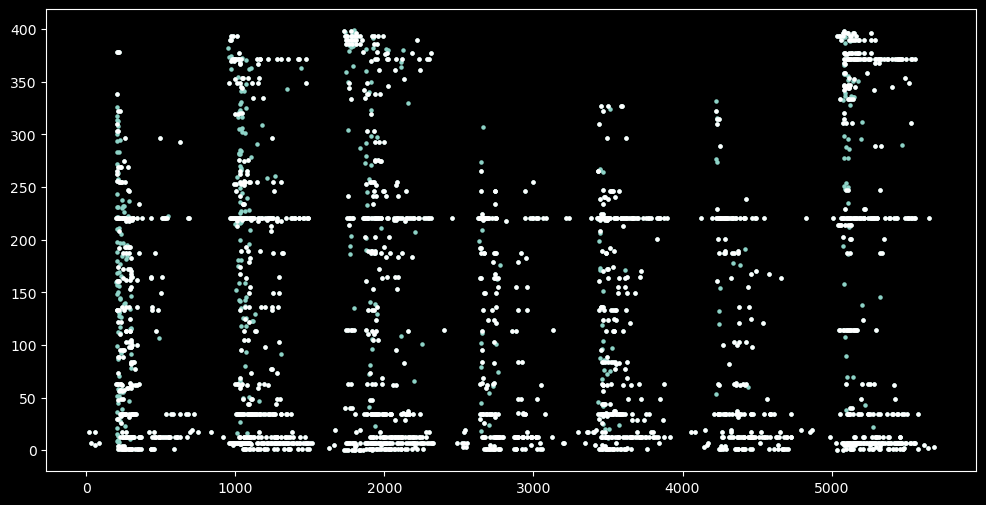

In [69]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]==1)[1]], np.where(sanity_check[:,patterns[counts>=2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

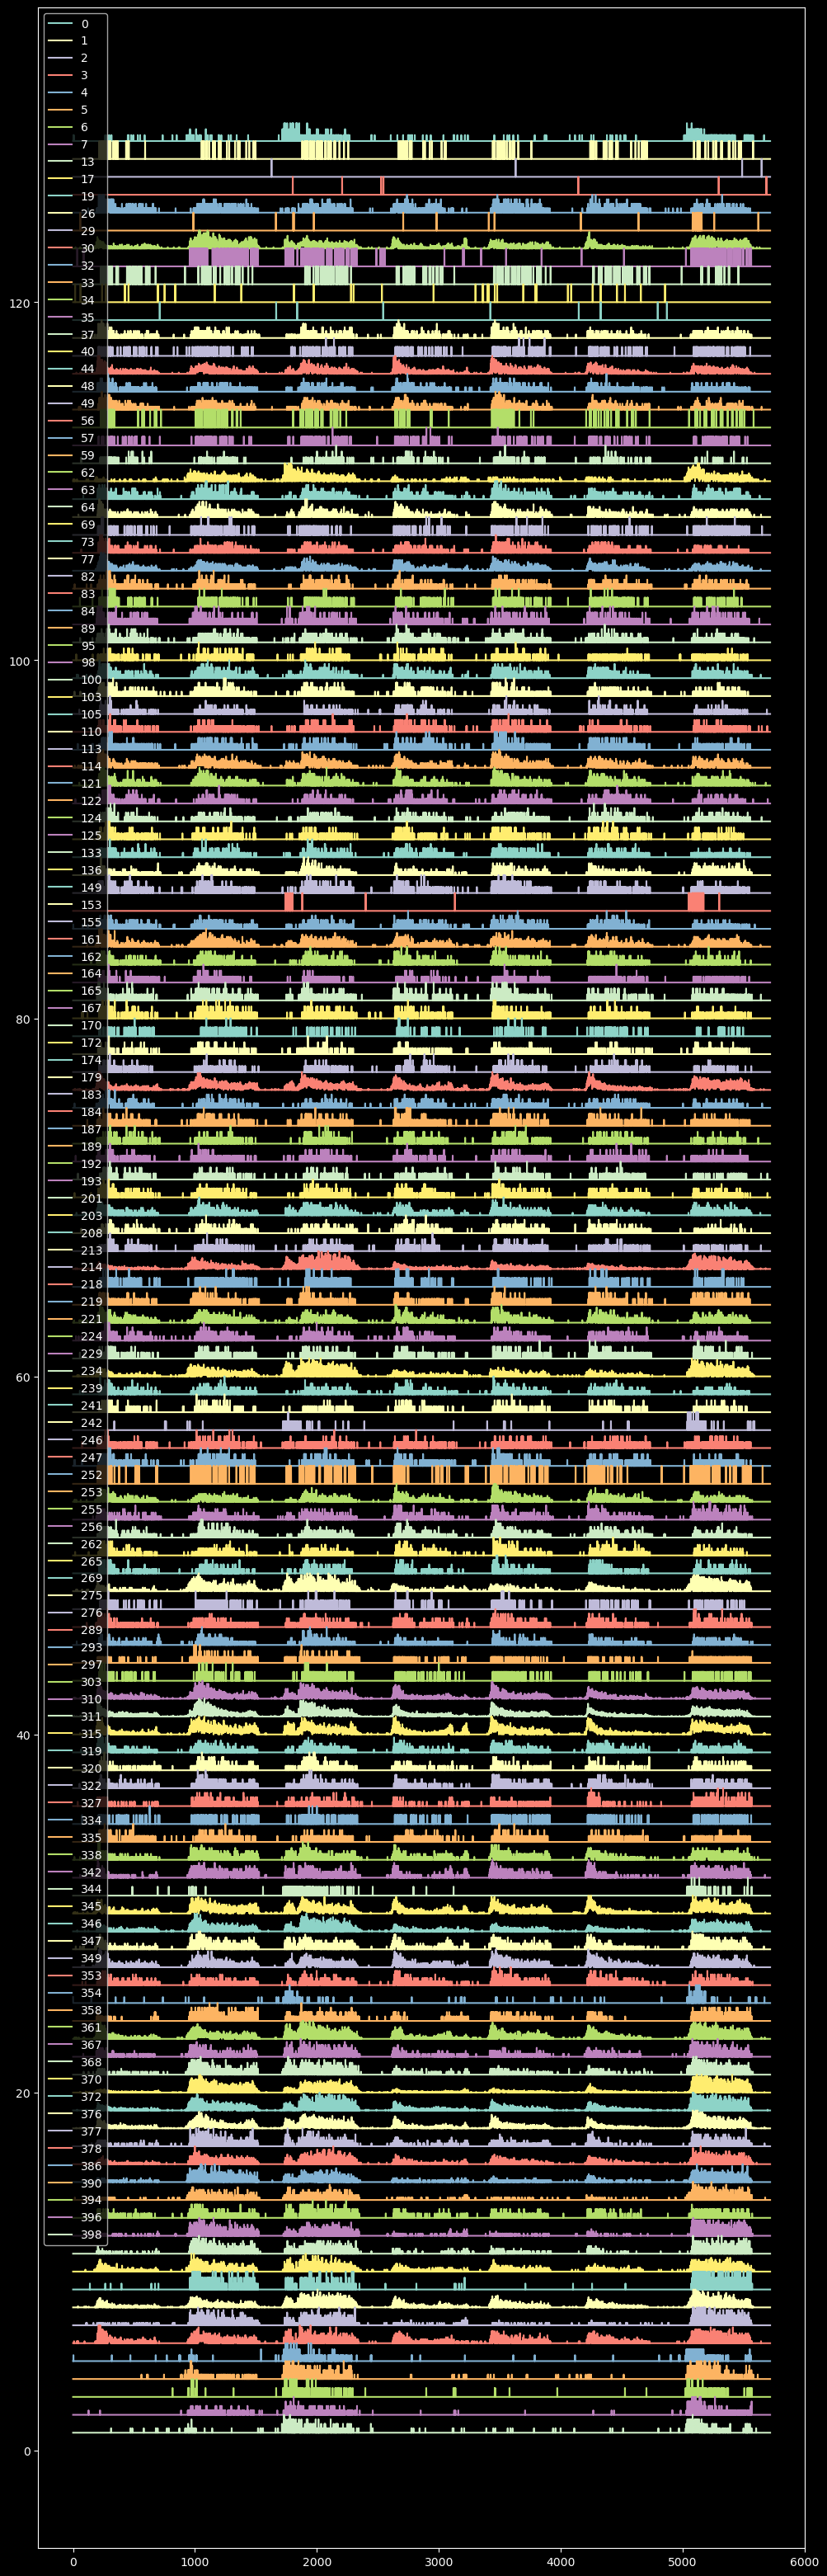

In [70]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>=2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>=2])-i,label=k)
    plt.legend()
plt.show()

# Now let's look at spoken digits that are NOT 0

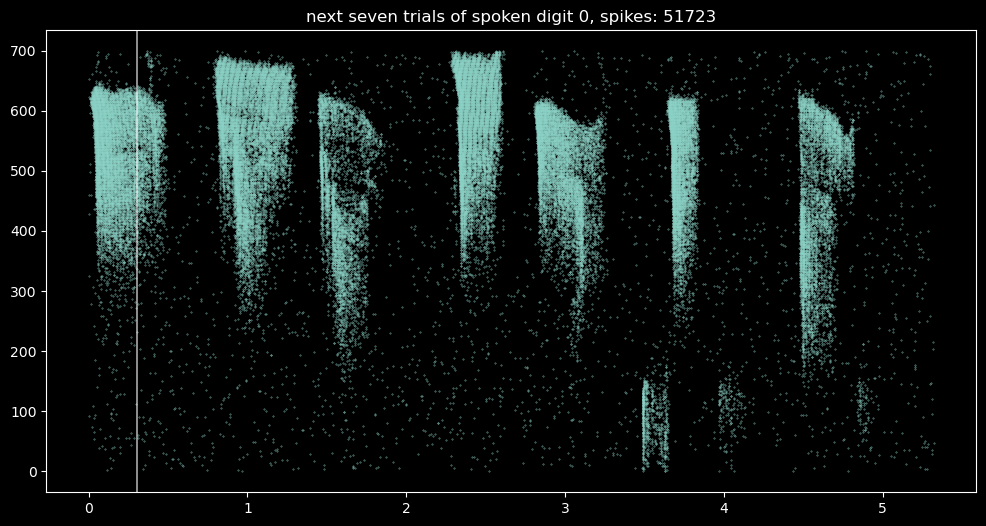

In [71]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])!=0))[0][3:10]

D=5/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

# plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.title(f'next seven trials of spoken digit 0, spikes: {len(times)}')

plt.show()

In [72]:
raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(5325, 700) (700, 19, 400)
done


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:13<00:00,  5.43it/s]


In [73]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>=2]), np.array(counts[counts>=2]), np.array([len(k) for k in pattern_template[patterns[counts>=2]]])

(array([  0,   1,   2,   3,   5,   6,   7,   8,  11,  12,  17,  19,  21,
         23,  24,  26,  27,  29,  32,  33,  34,  37,  39,  41,  43,  49,
         52,  55,  60,  62,  64,  66,  68,  69,  71,  76,  77,  80,  82,
         83,  84,  85,  86,  87,  88,  89,  91,  94,  96,  98, 101, 103,
        104, 106, 107, 109, 111, 112, 113, 114, 115, 116, 117, 119, 120,
        127, 128, 130, 134, 139, 146, 147, 149, 150, 159, 161, 162, 163,
        164, 165, 167, 170, 172, 176, 178, 179, 181, 183, 185, 189, 191,
        192, 193, 195, 197, 204, 205, 207, 208, 213, 218, 219, 221, 223,
        227, 228, 229, 231, 237, 238, 239, 241, 242, 246, 252, 253, 255,
        259, 261, 263, 264, 266, 273, 275, 276, 280, 287, 288, 292, 293,
        297, 301, 303, 305, 307, 310, 311, 320, 323, 324, 327, 330, 335,
        340, 341, 343, 344, 349, 351, 353, 354, 356, 359, 361, 365, 366,
        367, 372, 378, 380, 382, 386, 388, 390, 392, 396, 397, 398, 399],
       dtype=int64),
 array([  5, 136,   5,  16,  

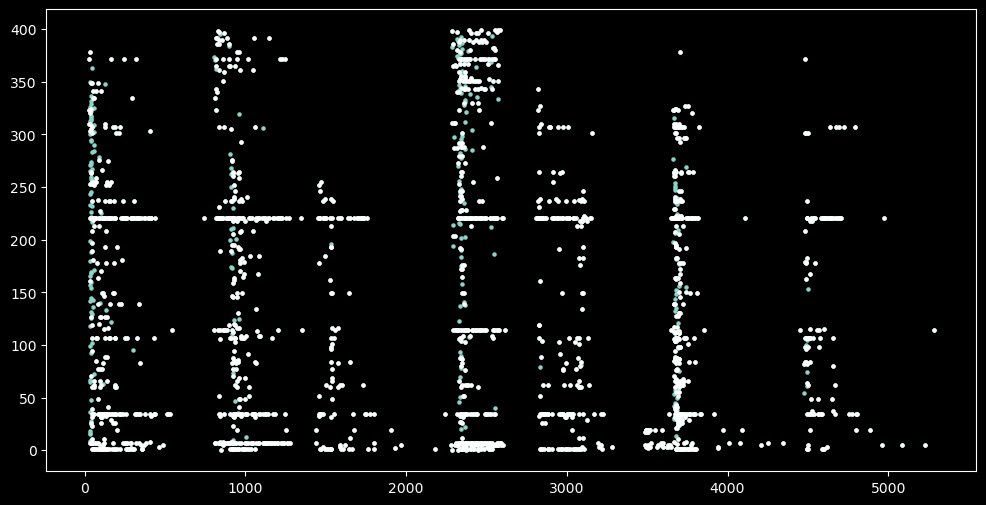

In [76]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]==1)[1]], np.where(sanity_check[:,patterns[counts>=2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

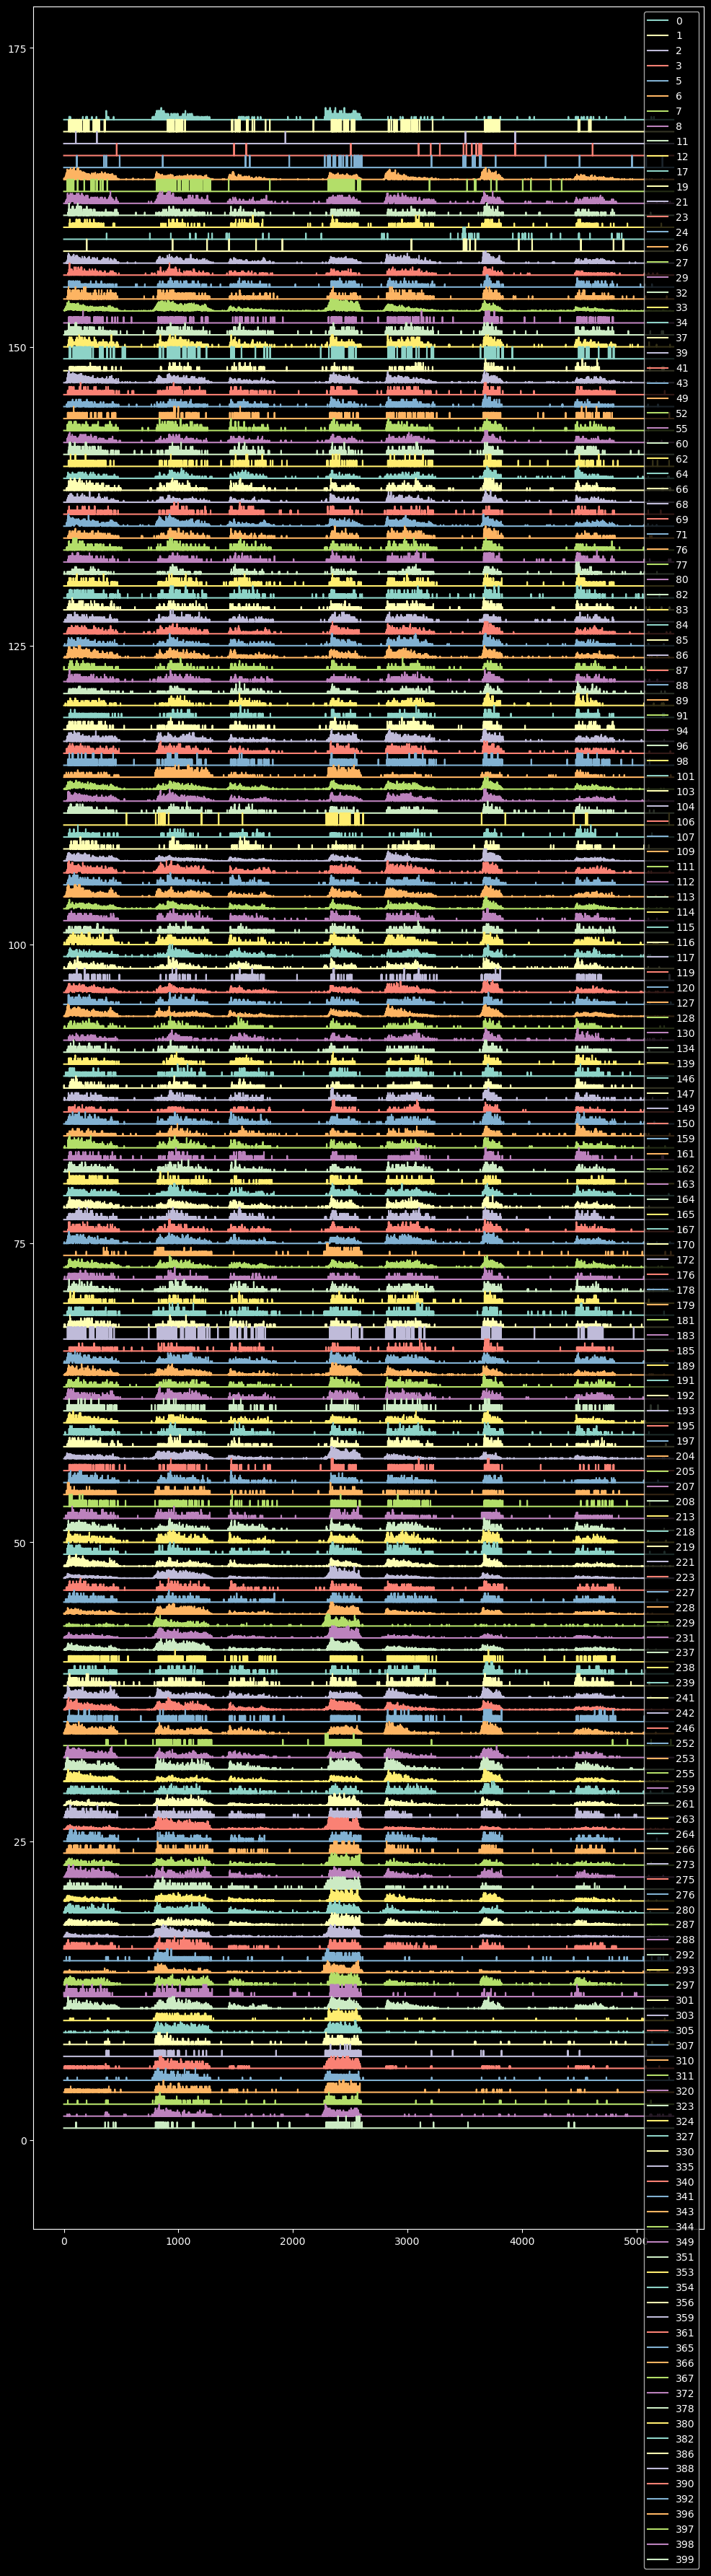

In [77]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>=2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>=2])-i,label=k)
    plt.legend()
plt.show()